In [1]:
import numpy as np
from scipy import misc
from mpl_toolkits.mplot3d import Axes3D 
import matplotlib.pyplot as plt 
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from pandas import DataFrame

In [2]:
%matplotlib notebook

In [3]:
def U(x, y): return np.exp(x*y)*np.cos(2*np.pi*(x+y))

In [4]:
def U_x(x, y): return misc.derivative(lambda s: U(s, y), x, dx=1e-6, n=1, args=(), order=5)

In [5]:
def U_y(x, y): return misc.derivative(lambda s: U(x, s), y, dx=1e-6, n=1, args=(), order=5)

In [6]:
def U_xx(x, y): return misc.derivative(lambda s: U(s, y), x, dx=1e-6, n=2, args=(), order=5)

In [7]:
def U_yy(x, y): return misc.derivative(lambda s: U(x, s), y, dx=1e-6, n=2, args=(), order=5)

In [8]:
def f(x, y): return np.exp(x*y)*np.cos(2*np.pi*(x+y))*(x**2+y**2-8*np.pi**2)-4*np.pi*np.exp(x*y)*np.sin(2*np.pi*(x+y))*(x+y)
#U_xx(x, y)+U_yy(x, y)
#np.exp(x*y)*np.cos(2*np.pi*(x+y))*(x**2+y**2-8*np.pi**2)-4*np.pi*np.exp(x*y)*np.sin(2*np.pi*(x+y))*(x+y)

In [9]:
def w(x, y): return U(x, y)

In [10]:
def q(x, y, hx, hy): return 2*np.pi*(hx+hy)*np.exp(x*y)*np.sin(2*np.pi*(x+y))-(hx*y+hy*x)*np.exp(x*y)*np.cos(2*np.pi*(x+y))
#-(hx*U_x(x, y)+hy*U_y(x, y))
#2*np.pi*(hx+hy)*np.exp(x*y)*np.sin(2*np.pi*(x+y))-(hx*y+hy*x)*np.exp(x*y)*np.cos(2*np.pi*(x+y))

In [11]:
def Norm(M): return np.amax(np.absolute(M))

In [12]:
def diff_ex(x, y, z, h): return (x-2*y+z)/h**2

In [13]:
def diff_OP(M, h):
    Op1 = [M[0]]+[[0 for i in range(len(M[0]))] for j in range(len(M)-2)]+[M[len(M)-1]]
    for j in range(1, len(M)-1):
        Op1[j] = [diff_ex(M[j-1][m], M[j][m], M[j+1][m], h) for m in range(len(M[0]))]
    return Op1

In [14]:
#Binomial coefficient
def Perm(n, k):
    if k == 0: return 1
    elif k > n: return 0
    else: return Perm(n - 1, k) + Perm(n - 1, k - 1)

In [15]:
#reduction of a matrix with long boundary conditions to a tridiagonal form
def to_tri(a, b, c, d, C_Vh, B_Vh, p1, p2):
    if p1==1 and p2==1: 
        a = B_Vh[1]
        b = [C_Vh[0], B_Vh[0]]
        c = C_Vh[1]
        return a, b[0], b[1], c, d[0], d[len(d)-1]
    elif p1>1:
        C_Vh[p1-2] -= a*C_Vh[p1]/c
        C_Vh[p1-1] -= b*C_Vh[p1]/c
        d[0] -= d[p1-1]*C_Vh[p1]/c
        C_Vh.pop()
        p1-=1
    elif p2>1:
        B_Vh[p2-2] -= c*B_Vh[p2]/a
        B_Vh[p2-1] -= b*B_Vh[p2]/a
        d[len(d)-1] -= d[len(d)-p2]*B_Vh[p2]/a
        B_Vh.pop()
        p2-=1
    return to_tri(a, b, c, d, C_Vh, B_Vh, p1, p2)

In [16]:
def TDMA(a, b, c, d):
    nf = len(d)
    ac, bc, cc, dc = map(np.array, (a, b, c, d))
    for it in range(1, nf):
        mc = ac[it-1]/bc[it-1]
        bc[it] = bc[it] - mc*cc[it-1] 
        dc[it] = dc[it] - mc*dc[it-1]
        	    
    xc = bc
    xc[-1] = dc[-1]/bc[-1]

    for il in range(nf-2, -1, -1):
        xc[il] = (dc[il]-cc[il]*xc[il+1])/bc[il]

    return xc

In [17]:
#scs_from_task
#Solution of the Poisson Equation by the method of establishing
#(scheme of stabilizing correction; left, right - Neumann boundary conditions; top, bottom - Dirichlet)
#[a, b]-Xinterval, [c, d]-Yinterval; Nx, Ny - number of nodes X, Y; tau - parametr(time); eps - error; 
#p1, p2, p3, p4 - orders of approximation; lim_it - iteration limit;  
def SPE_A(a, b, c, d, Nx, Ny, tau, eps, p1, p2, p3, p4, lim_it):
    X_nod = np.linspace(a, b, Nx+1)
    Y_nod = np.linspace(c, d, Ny+1)
    h1, h2, count_it, epsn = (b-a)/Nx, (d-c)/Ny, 0, eps+1
    Vb, Vh, Vr = np.zeros((Nx+1, Ny+1)), np.zeros((Ny+1, Nx+1)), np.zeros((Nx+1, Ny+1))
    C_Vh = [0.0] + [(-1)**(m+1)*Perm(p1, m)/(m) for m in range(1, p1+1)]
    B_Vh = [0.0] + [(-1)**(m+2)*Perm(p2, m)/(m) for m in range(1, p2+1)]
    C_Vr = [0.0] + [(-1)**(m+1)*Perm(p3, m)/(m) for m in range(1, p3+1)]
    B_Vr = [0.0] + [(-1)**(m+2)*Perm(p4, m)/(m) for m in range(1, p4+1)]
    B_Vh[0], C_Vh[0], B_Vr[0], C_Vr[0] = -sum(B_Vh), -sum(C_Vh), -sum(B_Vr), -sum(C_Vr)
    ah, bh, ch, dh = [-1/(h1**2) for i in range(Nx)], [(2/(h1**2)+1/tau) for i in range(Nx+1)], [-1/(h1**2) for i in range(Nx)], np.zeros(Nx+1)
    ar, br, cr, dr = [1.0 for i in range(Ny-1)]+[0.0], [1.0]+[-(h2**2)/tau-2 for i in range(Ny-1)]+[1.0], [0.0]+[1.0 for i in range(Ny-1)], np.zeros(Ny+1)
    X_msh, Y_msh = np.meshgrid(X_nod, Y_nod)
    Ur = U(X_msh, Y_msh)
    while epsn>=eps and count_it<=lim_it:
        for m in range(1, Ny): 
            dh[0], dh[Nx] = h1*q(X_nod[0], Y_nod[m], -1, 0), -h1*q(X_nod[Nx], Y_nod[m], 1, 0)
            for j in range(1, Nx): dh[j] = (1/(h2**2))*Vb[j][m-1]+(1/tau-2/(h2**2))*Vb[j][m]+(1/(h2**2))*Vb[j][m+1]-f(X_nod[j], Y_nod[m])
            ah[Nx-1], bh[0], bh[Nx], ch[0], dh[0], dh[Nx] = to_tri(ah[1], bh[1], ch[1], dh.copy(), C_Vh.copy(), B_Vh.copy(), p1, p2)
            Vh[m] = TDMA(ah, bh, ch, dh)
        for j in range(1, Nx):
            dr[0], dr[Ny] = w(X_nod[j], Y_nod[0]), w(X_nod[j], Y_nod[Ny])
            for m in range(1, Ny): dr[m] = (1.0)*Vb[j][m-1]+(-2.0)*Vb[j][m]+(1.0)*Vb[j][m+1]+(-(h2**2)/tau)*Vh[m][j]
            Vr[j] = TDMA(ar, br, cr, dr)
        Vr[0] = [(h1*q(X_nod[0], Y_nod[i], -1, 0)-np.dot(C_Vr[1::], [Vr[j][i] for j in range(1, p3+1)]))/C_Vr[0] for i in range(Ny+1)]
        Vr[Nx] = [(-h1*q(X_nod[Nx], Y_nod[i], 1, 0)-np.dot(B_Vr[1::], [Vr[Nx-j][i] for j in range(1, p4+1)]))/B_Vr[0] for i in range(Ny+1)]
        #epsn = Norm(np.array(diff_OP(Vr, h1))+np.transpose(diff_OP(np.transpose(Vr), h2))-np.array([[f(x, y) for y in Y_nod] for x in X_nod]))
        epsn = Norm(np.transpose(Vr)-Ur)
        Vb = Vr.copy()
        count_it+=1
    return np.transpose(Vr), X_nod, Y_nod, count_it

In [18]:
#scs_from_book
def SPE_B(a, b, c, d, Nx, Ny, tau, eps, p1, p2, p3, p4, lim_it):
    X_nod = np.linspace(a, b, Nx+1)
    Y_nod = np.linspace(c, d, Ny+1)
    h1, h2, count_it, epsn = (b-a)/Nx, (d-c)/Ny, 0, eps+1
    Vb, Vh, Vr = np.zeros((Nx+1, Ny+1)), np.zeros((Ny+1, Nx+1)), np.zeros((Nx+1, Ny+1))
    C_Vh = [0.0] + [(-1)**(m+1)*Perm(p1, m)/(m) for m in range(1, p1+1)]
    B_Vh = [0.0] + [(-1)**(m+2)*Perm(p2, m)/(m) for m in range(1, p2+1)]
    B_Vh[0], C_Vh[0] = -sum(B_Vh), -sum(C_Vh)
    ah, bh, ch, dh = [-0.5 for i in range(Nx)], [((h1**2)/tau)+1.0 for i in range(Nx+1)], [-0.5 for i in range(Nx)], np.zeros(Nx+1)
    ar, br, cr, dr = [-0.5 for i in range(Ny-1)]+[0.0], [1.0]+[((h2**2)/tau)+1.0 for i in range(Ny-1)]+[1.0], [0.0]+[-0.5 for i in range(Ny-1)], np.zeros(Ny+1)
    while epsn>=eps and count_it<=lim_it:
        for m in range(1, Ny): 
            dh[0], dh[Nx] = h1*q(X_nod[0], Y_nod[m], -1, 0), -h1*q(X_nod[Nx], Y_nod[m], 1, 0)
            for j in range(1, Nx): dh[j] = (0.5)*Vb[j-1][m]+(-1.0-2.0*(h1/h2)**2)*Vb[j][m]+(0.5)*Vb[j+1][m]+((h1/h2)**2)*Vb[j][m-1]+((h1/h2)**2)*Vb[j][m+1]+(h1**2)*f(X_nod[j], Y_nod[m])
            ah[Nx-1], bh[0], bh[Nx], ch[0], dh[0], dh[Nx] = to_tri(ah[1], bh[1], ch[1], dh.copy(), C_Vh.copy(), B_Vh.copy(), p1, p2)
            Vh[m] = TDMA(ah, bh, ch, dh)
        for j in range(1, Nx):
            dr[0], dr[Ny] = w(X_nod[j], Y_nod[0]), w(X_nod[j], Y_nod[Ny])
            for m in range(1, Ny): dr[m] = (-0.5)*Vb[j][m-1]+(1.0)*Vb[j][m]+(-0.5)*Vb[j][m+1]+((h2**2)/tau)*Vh[m][j]
            Vr[j] = TDMA(ar, br, cr, dr)
        #Vr[0] =
        #Vr[Nx] =
        epsn = Norm(np.array(diff_OP(Vr, h1))+np.transpose(diff_OP(np.transpose(Vr), h2))-np.array([[f(x, y) for y in Y_nod] for x in X_nod]))
        Vb = Vr.copy()
        count_it+=1
    return np.transpose(Vr), X_nod, Y_nod, count_it

In [19]:
#spe_b_with_srandard_Vr_matrix; 
def SPE_St_B(a, b, c, d, Nx, Ny, tau, eps, p1, p2, p3, p4, lim_it):
    X_nod = np.linspace(a, b, Nx+1)
    Y_nod = np.linspace(c, d, Ny+1)
    h1, h2, count_it, epsn = (b-a)/Nx, (d-c)/Ny, 0, eps+1
    Vb, Vh, Vr = np.zeros((Ny+1, Nx+1)), np.zeros((Ny+1, Nx+1)), np.zeros((Ny+1, Nx+1))
    C_Vh = [0.0] + [(-1)**(m+1)*Perm(p1, m)/(m) for m in range(1, p1+1)]
    B_Vh = [0.0] + [(-1)**(m+2)*Perm(p2, m)/(m) for m in range(1, p2+1)]
    B_Vh[0], C_Vh[0] = -sum(B_Vh), -sum(C_Vh)
    ah, bh, ch, dh = [-0.5 for i in range(Nx)], [((h1**2)/tau)+1.0 for i in range(Nx+1)], [-0.5 for i in range(Nx)], np.zeros(Nx+1)
    ar, br, cr, dr = [-0.5 for i in range(Ny-1)]+[0.0], [1.0]+[((h2**2)/tau)+1.0 for i in range(Ny-1)]+[1.0], [0.0]+[-0.5 for i in range(Ny-1)], np.zeros(Ny+1)
    while epsn>=eps and count_it<=lim_it:
        for m in range(1, Ny): 
            dh[0], dh[Nx] = h1*q(X_nod[0], Y_nod[m], -1, 0), -h1*q(X_nod[Nx], Y_nod[m], 1, 0)
            for j in range(1, Nx): dh[j] = (0.5)*Vb[m][j-1]+(-1.0-2.0*((h1**2)/(h2**2)))*Vb[m][j]+(0.5)*Vb[m][j+1]+((h1**2)/(h2**2))*Vb[m-1][j]+((h1**2)/(h2**2))*Vb[m+1][j]+(h1**2)*f(X_nod[j], Y_nod[m])
            ah[Nx-1], bh[0], bh[Nx], ch[0], dh[0], dh[Nx] = to_tri(ah[1], bh[1], ch[1], dh.copy(), C_Vh.copy(), B_Vh.copy(), p1, p2)
            Vh[m] = TDMA(ah, bh, ch, dh)
        for j in range(1, Nx):
            dr[0], dr[Ny] = w(X_nod[j], Y_nod[0]), w(X_nod[j], Y_nod[Ny])
            for m in range(1, Ny): dr[m] = (-0.5)*Vb[m-1][j]+(1.0)*Vb[m][j]+(-0.5)*Vb[m+1][j]+((h2**2)/tau)*Vh[m][j]
            vect = TDMA(ar, br, cr, dr)
            for m in range(Ny+1): Vr[m][j] = vect[m]
        #Vr[0] =    
        #Vr[Nx] =
        epsn = Norm(np.array(diff_OP(Vr, h1))+np.transpose(diff_OP(np.transpose(Vr), h2))-np.array([[f(x, y) for x in X_nod] for y in Y_nod]))
        Vb = Vr.copy()
        count_it+=1
    return Vr, X_nod, Y_nod, count_it

In [20]:
#spe_a_for_dirichle_boundary_cond;
def SPE_A_Dr(a, b, c, d, Nx, Ny, tau, eps, p1, p2, p3, p4, lim_it):
    X_nod = np.linspace(a, b, Nx+1)
    Y_nod = np.linspace(c, d, Ny+1)
    h1, h2, count_it, epsn = (b-a)/Nx, (d-c)/Ny, 0, eps+1
    Vb, Vh, Vr = np.zeros((Nx+1, Ny+1)), np.zeros((Ny+1, Nx+1)), np.zeros((Nx+1, Ny+1))
    ah, bh, ch, dh = [-1/(h1)**(2) for i in range(Nx-1)]+[0.0], [1.0]+[(2/(h1)**2 + 1/tau) for i in range(Nx-1)]+[1.0], [0.0]+[-1/(h1)**(2) for i in range(Nx-1)], np.zeros(Nx+1)
    ar, br, cr, dr = [1.0 for i in range(Ny-1)]+[0.0], [1.0]+[(-(h2)**2/tau - 2) for i in range(Ny-1)]+[1.0], [0.0]+[1.0 for i in range(Ny-1)], np.zeros(Ny+1)
    #F_val = np.array([[f(x, y) for y in Y_nod] for x in X_nod])
    X_msh, Y_msh = np.meshgrid(X_nod, Y_nod)
    Ur = U(X_msh, Y_msh)
    while epsn>=eps and count_it<=lim_it:
        for m in range(1, Ny): 
            dh[0], dh[Nx] = w(X_nod[0], Y_nod[m]), w(X_nod[Nx], Y_nod[m])
            for j in range(1, Nx): dh[j] = (1/(h2)**2)*Vb[j][m-1]+(1/tau - 2/(h2)**2)*Vb[j][m]+(1/(h2)**2)*Vb[j][m+1]-f(X_nod[j], Y_nod[m])
            Vh[m] = TDMA(ah, bh, ch, dh)
        for j in range(1, Nx):
            dr[0], dr[Ny] = w(X_nod[j], Y_nod[0]), w(X_nod[j], Y_nod[Ny])
            for m in range(1, Ny): dr[m] = Vb[j][m-1]+(-2)*Vb[j][m]+Vb[j][m+1]+(-(h2)**2/tau)*Vh[m][j]
            Vr[j] = TDMA(ar, br, cr, dr)
        Vr[0] = [w(X_nod[0], Y_nod[i]) for i in range(Ny+1)]
        Vr[Nx] = [w(X_nod[Nx], Y_nod[i]) for i in range(Ny+1)]
        #epsn = Norm(np.array(diff_OP(Vr, h1))+np.transpose(diff_OP(np.transpose(Vr), h2))-F_val)
        epsn = Norm(np.transpose(Vr)-Ur)
        Vb = Vr.copy()
        count_it+=1
    return np.transpose(Vr), X_nod, Y_nod, count_it

In [21]:
def SHOW_G(a, b, c, d, Nx, Ny, tau, eps, p1, p2, lim_it, METH, p3=3, p4=3):
    SOL = METH(a, b, c, d, Nx, Ny, tau, eps, p1, p2, p3, p4, lim_it)
    Xnd, Ynd = np.meshgrid(SOL[1], SOL[2])
    Ur = U(Xnd, Ynd)
    print("ER: ", Norm(SOL[0]-Ur), "IT: ", SOL[3])

    fig = plt.figure(figsize=plt.figaspect(0.5))
    ax = fig.add_subplot(1, 2, 1, projection='3d')
    surf = ax.plot_surface(Xnd, Ynd, SOL[0], cmap=cm.coolwarm, linewidth=0, antialiased=False)
    ax.zaxis.set_major_locator(LinearLocator(10))
    ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('u')
    
    ax = fig.add_subplot(1, 2, 2, projection='3d') 
    Xnd, Ynd = np.meshgrid(np.linspace(a, b, 101), np.linspace(c, d, 101))
    surf = ax.plot_surface(Xnd, Ynd, U(Xnd, Ynd), cmap=cm.coolwarm, linewidth=0, antialiased=False)
    ax.zaxis.set_major_locator(LinearLocator(10))
    ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('u')

In [22]:
def SHOW_T_lim(a, b, c, d, Nx, Ny, tau, Nx_jmp, Ny_jmp, tau_jmp, it, p1, p2, lim_it, METH, p3=3, p4=3):
    dataset = []
    for i in range(it):
        SOL = METH(a, b, c, d, Nx*Nx_jmp**i, Ny*Ny_jmp**i, tau*tau_jmp**i, 1e-10, p1, p2, p3, p4, lim_it)
        X_nod, Y_nod = np.meshgrid(SOL[1], SOL[2])
        dataset.append(Norm(SOL[0]-U(X_nod, Y_nod)))
    print(DataFrame(np.array(dataset), 
                       index=["Nx="+str(Nx*Nx_jmp**i)+";Ny="+str(Ny*Ny_jmp**i)+";tau="+str(tau*tau_jmp**i) for i in range(it)], 
                    columns=["__ERR__"]
                      ))

In [23]:
def SHOW_T_eps(a, b, c, d, Nx, Ny, tau, Nx_jmp, Ny_jmp, tau_jmp, it, eps, p1, p2, lim_it, METH, p3=3, p4=3):
    dataset = []
    for i in range(it):
        SOL = METH(a, b, c, d, Nx*Nx_jmp**i, Ny*Ny_jmp**i, tau*tau_jmp**i, eps, p1, p2, p3, p4, lim_it)
        X_nod, Y_nod = np.meshgrid(SOL[1], SOL[2])
        dataset.append([Norm(SOL[0]-U(X_nod, Y_nod)), SOL[3]])
    print(DataFrame(np.array(dataset), 
                       index=["Nx="+str(Nx*Nx_jmp**i)+";Ny="+str(Ny*Ny_jmp**i)+";tau="+str(tau*tau_jmp**i) for i in range(it)], 
                    columns=["__ERR__", "_IT_"]
                      ))

In [24]:
def SHOW_T_delta(a, b, c, d, Nx, Ny, tau, Nx_jmp, Ny_jmp, tau_jmp, it, eps, p1, p2, lim_it, METH, p3=3, p4=3):
    dataset = []
    for i in range(it):
        SOL = METH(a, b, c, d, Nx*Nx_jmp**i, Ny*Ny_jmp**i, tau*tau_jmp**i, eps, p1, p2, p3, p4, lim_it)
        X_nod, Y_nod = np.meshgrid(SOL[1], SOL[2])
        Ur = U(X_nod, Y_nod)
        dataset.append([Norm(SOL[0]-Ur)/Norm(Ur), SOL[3]])
    print(DataFrame(np.array(dataset), 
                       index=["Nx="+str(Nx*Nx_jmp**i)+";Ny="+str(Ny*Ny_jmp**i)+";tau="+str(tau*tau_jmp**i) for i in range(it)], 
                    columns=["relative_ERR", "_IT_"]
                      ))

ER:  0.00907160919369 IT:  22


<IPython.core.display.Javascript object>


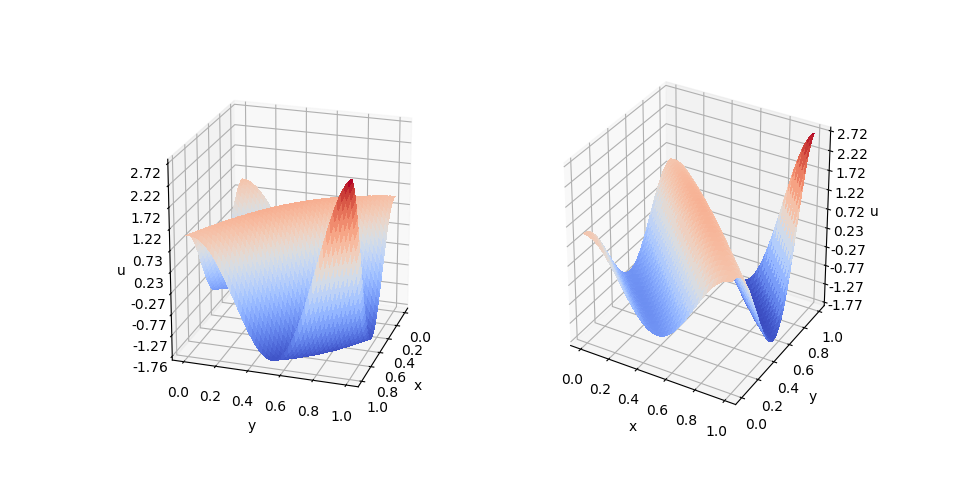

In [232]:
SHOW_G(0, 1, 0, 1, 48, 96, 0.01, 0.01, 4, 4, 100, SPE_A)

In [244]:
SHOW_T_lim(0, 1, 0, 1, 3, 6, 0.16, 2, 2, 0.5, 5, 4, 4, 100, SPE_A)

                       __ERR__
Nx=3;Ny=6;tau=0.16    4.738028
Nx=6;Ny=12;tau=0.08   0.767538
Nx=12;Ny=24;tau=0.04  0.080673
Nx=24;Ny=48;tau=0.02  0.012953
Nx=48;Ny=96;tau=0.01  0.002974


In [260]:
SHOW_T_eps(0, 1, 0, 1, 3, 6, 0.16, 2, 2, 0.5, 5, 0.01, 4, 4, 100, SPE_A)

                       __ERR__   _IT_
Nx=3;Ny=6;tau=0.16    4.738028  101.0
Nx=6;Ny=12;tau=0.08   0.767538  101.0
Nx=12;Ny=24;tau=0.04  0.080673  101.0
Nx=24;Ny=48;tau=0.02  0.009248   14.0
Nx=48;Ny=96;tau=0.01  0.009072   22.0


In [261]:
SHOW_T_delta(0, 1, 0, 1, 3, 6, 0.16, 2, 2, 0.5, 5, 0.01, 4, 4, 100, SPE_A)

                      relative_ERR   _IT_
Nx=3;Ny=6;tau=0.16        1.743023  101.0
Nx=6;Ny=12;tau=0.08       0.282361  101.0
Nx=12;Ny=24;tau=0.04      0.029678  101.0
Nx=24;Ny=48;tau=0.02      0.003402   14.0
Nx=48;Ny=96;tau=0.01      0.003337   22.0
